# Refactoring the training code for the text classifier on user complaints' reviews 

In [1]:
import argparse, os
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import set_random_seed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, AdamW

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback



2023-09-23 10:25:02.081416: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-23 10:25:03.609157: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-23 10:25:03.613417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 10:25:08.037273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import params


In [3]:
# defaults
default_config = {
    "framework": "keras",
    "kernel_size": 32, # Kernels
    "filter_size": 7, # n of filters
    "lr": 2e-3,
    "weight_decay": 0.9,
    "log_preds": True,
    "embedding_size": 128,
    "max_tokens": 128,
    "batch_size": 128,
    "cnn_layers": 1,
    "epochs": 5,
    "dropout": 0,
    "num_classes": 5,
    "pretrained": False,
    "seed": 42
}


Helper functions to download and prepare the dataset

In [4]:
type(default_config)

dict

In [5]:
def download_data():
    # Define the artifact to use
    processed_data_at = run.use_artifact(f'{params.PROCESSED_DATA_AT}:latest', type='split_data')
    # Download the data in the artifact
    processed_dataset_dir = Path(processed_data_at.download())
    return processed_dataset_dir

def get_target_dict(df):
    # Extract the unique category values
    target_classes = df['product'].unique()
    # Create a dictionary
    target_values = dict(zip(target_classes, range(5)))

    return target_values, target_classes

def get_datasets(processed_dataset_dir):
    # Read the data from the artifact as a csv file
    df = pd.read_csv(processed_dataset_dir / params.SPLIT_FILENAME)
    # GEt target values
    target_values, target_classes = get_target_dict(df)
    # Replace values in column product with integer values using the dict
    df.replace({'product': target_values}, inplace=True)
    # Create the train dataset
    X_train= df[df['stage']=='train']['narrative'].values
    y_train= df[df['stage']=='train']['product'].values
    # Create the validation dataset
    X_val= df[df['stage']=='validation']['narrative'].values
    y_val= df[df['stage']=='validation']['product'].values
    # Create the validation dataset
    X_test= df[df['stage']=='test']['narrative'].values
    y_test= df[df['stage']=='test']['product'].values

    return X_train, y_train, X_val, y_val, X_test, y_test, target_values, target_classes


In [6]:
def tokenize_text(X_train,X_val,X_test,max_tokens, tokenizer):
    # Adjust the tokenizer
    tokenizer.fit_on_texts(np.concatenate([X_train,X_val]))

    ## Vectorizing data to keep max_tokens words per sample.
    X_train_vect = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_tokens, padding="post", truncating="post", value=0.)
    X_val_vect  = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_tokens, padding="post", truncating="post", value=0.)
    X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_tokens, padding="post", truncating="post", value=0.)

    return X_train_vect, X_val_vect, X_test_vect


In [7]:
def create_model(tokenizer, embed_len, max_tokens, n_kernel, n_filter, target_values):
    # Create the input layer
    inputs = Input(shape=(max_tokens, ))
    # Embedding layer
    embeddings_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embed_len,  input_length=max_tokens)
    # Create a Conv1D layer
    conv = Conv1D(n_kernel, n_filter, padding="same") ## Channels last
    # Create the final Dense layer
    dense = Dense(len(target_values), activation="softmax")
    # Build the model
    x = embeddings_layer(inputs)
    x = conv(x)
    x = tf.reduce_max(x, axis=1)
    output = dense(x)

    model = Model(inputs=inputs, outputs=output)

    return model


In [23]:
def evaluate_model(model, X_val, X_val_vect, y_val, target_classes,log_preds):
    val_preds = model.predict(X_val_vect)
    # Create the classification report
    report = classification_report(y_val, np.argmax(val_preds, axis=1), target_names=target_classes, output_dict=True)
    # Create a df with the report
    df_report = pd.DataFrame(report).transpose()
    df_report.reset_index(inplace=True)
    df_report = df_report.rename(columns = {'index':'category'})
    # Draw the confussion matrix for the test dataset
    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in y_val], [target_classes[i] for i in np.argmax(val_preds, axis=1)],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Blues",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        );
    plt.xticks(rotation=90)
    plt.savefig('confussion_matrix.png')

    if log_preds:
        df_val= pd.concat([pd.Series(X_val), pd.Series(y_val), pd.DataFrame(val_preds), pd.Series(np.argmax(val_preds, axis=1))], axis=1)
        df_val.columns = ['complaint','product','prob0','prob1','prob2','prob3','prob4','prediction']

    return df_report, df_val, 'confussion_matrix.png'


Lets start the body of the `train`function

In [9]:
config = default_config

In [10]:
default_config['seed']

42

In [11]:
# Set the seed for reproducibility
set_random_seed(default_config['seed'])


In [12]:
# Init the wandb session in our project
run = wandb.init(project=params.WANDB_PROJECT, entity=None, job_type="tuning", config=config)
# good practice to inject params using sweeps
config = wandb.config


wandb: Currently logged in as: edumunozsala. Use `wandb login --relogin` to force relogin


In [13]:
params.PROCESSED_DATA_AT,params.HPTUNING_DATA_AT

('consumer_complaints_split', 'consumer_complaints_hptuning')

In [14]:
# Download the data in the artifact
processed_dataset_dir = download_data()

wandb: Downloading large artifact consumer_complaints_split:latest, 98.06MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.8


In [15]:
# Split the datasets
X_train, y_train, X_val, y_val, X_test, y_test, target_values, target_classes = get_datasets(processed_dataset_dir)


In [16]:
# Create the tokenizer
tokenizer = Tokenizer()
# Tokenize the texts
X_train_vect, X_val_vect, X_test_vect = tokenize_text(X_train,X_val,X_test, config.max_tokens, tokenizer)


In [17]:
# Define the model
model = create_model(tokenizer, config.embedding_size, config.max_tokens, config.kernel_size, config.filter_size, target_values)
# Create the optimizer
#adam_optimizer = Adam(learning_rate=config.lr, decay=config.lr/config.epochs)
adam_optimizer = AdamW(learning_rate=config.lr, weight_decay=config.weight_decay)

# Compile the model
model.compile(adam_optimizer, "sparse_categorical_crossentropy", metrics=["accuracy"])

In [18]:
# Create the callbacks
#callbacks = [WandbCallback(monitor="val_accuracy", mode="max", log_preds=config.log_preds, log_model=True, save_model=True),]
#                 WandbModelCheckpoint(filepath="model-{epoch:02d}", monitor="val_accuracy", save_best_only=True, mode="max"),]

callbacks= [EarlyStopping(monitor='val_accuracy', patience = 2, restore_best_weights = False),
            WandbMetricsLogger(),
            WandbModelCheckpoint(filepath="model", monitor="val_accuracy", save_best_only=True, mode="max"),]

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [19]:
# Fit the model
history = model.fit(X_train_vect, y_train, batch_size=config.batch_size, epochs=config.epochs, validation_data=(X_val_vect, y_val),
                    callbacks=[callbacks])


Epoch 1/5
402/402 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.7907INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
wandb: Adding directory to artifact (./model)... Done. 0.2s


402/402 [==============================] - 54s 131ms/step - loss: 0.6203 - accuracy: 0.7907 - val_loss: 0.4762 - val_accuracy: 0.8373
Epoch 2/5
402/402 [==============================] - ETA: 0s - loss: 0.4276 - accuracy: 0.8557INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
wandb: Adding directory to artifact (./model)... Done. 0.2s


402/402 [==============================] - 54s 134ms/step - loss: 0.4276 - accuracy: 0.8557 - val_loss: 0.4627 - val_accuracy: 0.8438
Epoch 3/5
402/402 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8691INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
wandb: Adding directory to artifact (./model)... Done. 0.2s


402/402 [==============================] - 62s 154ms/step - loss: 0.3915 - accuracy: 0.8691 - val_loss: 0.4572 - val_accuracy: 0.8457
Epoch 4/5
402/402 [==============================] - ETA: 0s - loss: 0.3689 - accuracy: 0.8769INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
wandb: Adding directory to artifact (./model)... Done. 0.2s


402/402 [==============================] - 55s 138ms/step - loss: 0.3689 - accuracy: 0.8769 - val_loss: 0.4564 - val_accuracy: 0.8472
Epoch 5/5
402/402 [==============================] - ETA: 0s - loss: 0.3501 - accuracy: 0.8860

wandb: Adding directory to artifact (./model)... Done. 0.2s


402/402 [==============================] - 48s 120ms/step - loss: 0.3501 - accuracy: 0.8860 - val_loss: 0.4534 - val_accuracy: 0.8458


In [20]:
# Restore the best model
#model.load_weights("model")
model = tf.keras.models.load_model("model")#,compile=False)

In [21]:
config.log_preds

True

345/345 [==============================] - 3s 9ms/step


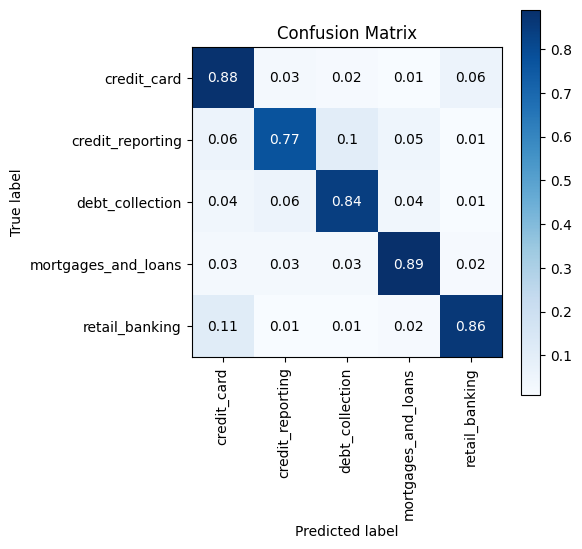

In [24]:
# Evaluate the model
df_report, df_val, conf_matrix = evaluate_model(model, X_val, X_val_vect, y_val, target_classes, config.log_preds)

Save artifacts to W&B

In [25]:
params.HPTUNING_DATA_AT = 'consumer_complaints_hptuning'

In [26]:
#Create the artifact
tuning_data_at = wandb.Artifact(params.HPTUNING_DATA_AT, type="tuning")
# Add the classifation report
tuning_data_at.add_file(conf_matrix)
# Save the classification report
report_table = wandb.Table(dataframe=df_report)
tuning_data_at.add(report_table, "classification_report")
# Save evaluation data
evaluation_table = wandb.Table(dataframe=df_val)
tuning_data_at.add(evaluation_table, "evaluation_table")

In [27]:
# Log artifacts
run.log_artifact(tuning_data_at)

<Artifact consumer_complaints_hptuning>

In [28]:
wandb.finish()

epoch/accuracy,▁▆▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▁▁
epoch/val_accuracy,▁▆▇█▇
epoch/val_loss,█▄▂▂▁
epoch/accuracy,0.88601
epoch/epoch,4
epoch/learning_rate,0.002
epoch/loss,0.3501
epoch/val_accuracy,0.8458
